# Network pruning for HSI band selection

In [1]:
from scipy import io
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.model_selection
from torch.nn import init
from tqdm import tqdm
import os
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import random
from torch.backends import cudnn
device = torch.device('cuda:{}'.format(0))
random.seed(7)
torch.manual_seed(7)
torch.cuda.manual_seed(7)
np.random.seed(7)
cudnn.deterministic = True

# 1. Load data

## 1.1 Load img and gt as numpy.ndarray

In [2]:
datasets = {
        'PaviaC': {
            'img': 'Pavia.mat',
            'gt': 'Pavia_gt.mat'
            },
        'PaviaU': {
            'img': 'PaviaU.mat',
            'gt': 'PaviaU_gt.mat'
            },
        'KSC': {
            'img': 'KSC.mat',
            'gt': 'KSC_gt.mat'
            },
        'IndianPines': {
            'img': 'Indian_pines_corrected.mat',
            'gt': 'Indian_pines_gt.mat'
            }}
dataset_name='IndianPines'
dataset=datasets[dataset_name]
folder = './Datasets/' +  dataset_name + '/'
print(folder)
img = io.loadmat(folder+dataset['img'])['indian_pines_corrected']   # Load image to numpy.ndarray

img= (img - np.min(img))/(np.max(img)-np.min(img))     # Normalization
print(type(img),img.shape)
gt = io.loadmat(folder + dataset['gt'])['indian_pines_gt']

./Datasets/IndianPines/
<class 'numpy.ndarray'> (145, 145, 200)


## 1.2 Visualization

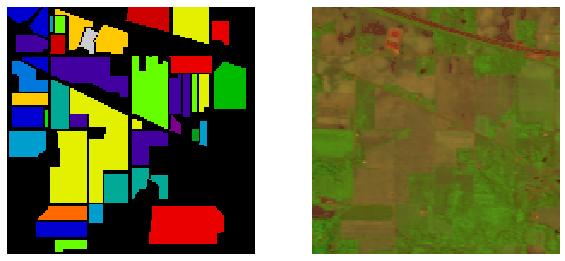

In [3]:
label_values = ["Undefined", "Alfalfa", "Corn-notill", "Corn-mintill",
                "Corn", "Grass-pasture", "Grass-trees",
                "Grass-pasture-mowed", "Hay-windrowed", "Oats",
                "Soybean-notill", "Soybean-mintill", "Soybean-clean",
                "Wheat", "Woods", "Buildings-Grass-Trees-Drives",
                "Stone-Steel-Towers"]

N_CLASSES = len(label_values)
N_BANDS = img.shape[-1]        # img shape H*W*C
fig=plt.figure(num=1,figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(gt,cmap='nipy_spectral')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(img[:,:,(10, 70, 121)]) 
plt.axis('off')
plt.show()

## 1.3 Training set and test set split

In [4]:
indices = np.nonzero(gt)
X = list(zip(*indices))
y = gt[indices] 
train_gt = np.zeros_like(gt)
test_gt = np.zeros_like(gt)
print('train_gt: ',type(train_gt),train_gt.shape)

train_indices, test_indices = sklearn.model_selection.train_test_split(X, train_size=0.05, random_state=0,stratify=y)

train_indices = list(zip(*train_indices))
print('train_indices: ',type(train_indices),len(train_indices))
test_indices = list(zip(*test_indices))
train_gt[train_indices] = gt[train_indices]
test_gt[test_indices] = gt[test_indices]


train_gt:  <class 'numpy.ndarray'> (145, 145)
train_indices:  <class 'list'> 2


/home/wqx/anaconda3/envs/pytorch1/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/home/wqx/anaconda3/envs/pytorch1/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


## 1.4 Define dataloader

In [5]:
class HSIdata(torch.utils.data.Dataset):
    def __init__(self,data,gt):
        super(HSIdata, self).__init__()
        self.data = data
        
        self.label = gt-1
        self.patch_size = 27
        self.data_all_offset = np.zeros((data.shape[0] + self.patch_size - 1, self.data.shape[1] + self.patch_size - 1, self.data.shape[2]))
        self.start = int((self.patch_size - 1) / 2)
        self.data_all_offset[self.start:data.shape[0] + self.start, self.start:data.shape[1] + self.start, :] = self.data[:, :, :]
        x_pos, y_pos = np.nonzero(gt)

        
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        self.labels = [self.label[x,y] for x,y in self.indices]
        
#         np.random.shuffle(self.indices)
        
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size

        data = self.data_all_offset[x:x+self.patch_size, y:y+self.patch_size]
        label = self.label[x, y]
        data = np.asarray(data.transpose((2, 0, 1)), dtype='float32')
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
#         print(type(data[6,6,1]),data.shape)
#         print(label)
        return data, label,x,y

train_dataset = HSIdata(img, train_gt)
train_loader = torch.utils.data.DataLoader(train_dataset,
                               batch_size=8,
                               shuffle=True)
test_dataset = HSIdata(img, test_gt)
test_loader = torch.utils.data.DataLoader(test_dataset,
                               batch_size=512,
                               shuffle=True)

# 2. Define Network structure with a pruning mask

In [6]:
class SELayer(nn.Module):

    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y=self.avg_pool(x).view(b,c)
        y=self.fc(y).view(b,c,1,1)
        return x*y.expand_as(x)
    
class BaseNet(nn.Module):

    def __init__(self, input_channels=200, n_classes=16, dropout=True):
        super(BaseNet, self).__init__()
        self.use_dropout = dropout
        if dropout:
            self.dropout = nn.Dropout(p=0.4)

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1, bias=False)
        self.mask1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1, bias=False)
        # select_number = [113,115,117,31,29,30,116,28,114,119]
        self.mask1.weight.data = torch.ones(self.mask1.weight.size())
        # self.mask1.weight.data[:,select_number[0:4],:,:]=1
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.se1 = SELayer(64)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.maxpooling = nn.MaxPool2d(2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(64, n_classes)

    def forward(self, x):
        self.conv1.weight.data = torch.mul(self.conv1.weight, self.mask1.weight)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x=self.maxpooling(x)
        x=self.se1(x)
        x = self.conv2(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.bn2(x)
        x = self.relu(x)

        x= self.maxpooling(x)
        if self.use_dropout:
            x = self.dropout(x)

        x = self.conv3(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    def channel_prune(self, rate):
        layer_mean = torch.sum(torch.sum(torch.sum(torch.abs(self.conv1.weight), axis=2), axis=2),axis=0)
        # rank = int(len(layer_mean.view(-1)) * rate)
        # T = sorted(layer_mean.view(-1).detach().cpu().numpy())[rank]
        T=np.percentile(layer_mean.view(-1).detach().cpu().numpy(), rate*100)
        new_mask = torch.gt(layer_mean, T).unsqueeze(0).unsqueeze(2).unsqueeze(2).expand_as(self.conv1.weight).float()
        self.mask1.weight.data = torch.mul(new_mask, self.mask1.weight.data)
        self.conv1.weight.data = torch.mul(self.conv1.weight, self.mask1.weight)


# 3. Utils

In [7]:
def adjust_learning_rate(optimizer, epoch,lr):
    if epoch < 1200:
        lr = lr * (0.5 ** (epoch // 200))
    else:
        lr = lr * (0.5 ** (800 // 200))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def save_model(model, model_name, dataset_name, epoch):
    model_dir = './checkpoints/' + model_name + "/" + dataset_name + "/"
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir, exist_ok=True)
    filename = str('w6') + "_epoch{}".format(epoch)
    print(filename)
    torch.save(model.state_dict(), model_dir + filename + '.pth')

def print_nonzeros(model):
    nonzero=total=0
    for name,p in model.named_parameters():
        if 'mask' in name:
            continue
        tensor=p.data.cpu().numpy()
        nz_count=np.count_nonzero(tensor)
        total_params=np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:10}|nonzeros= {nz_count}/ {total_params}')
    print(f'alive:{nonzero}, total:{total}, Compression_rate :{(total-nonzero)/total:10.2f}')

# 4. Train and test

In [8]:
def train(net, optimizer, critirian, data_loader, epoch):
    net.to(device)
    for e in range(1, epoch + 1):
        net.train()
        adjust_learning_rate(optimizer, e, lr)
        avg_loss = 0
        number = 0
        correct = 0
        for iter_, (data, target,x,y) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            a = np.array(torch.sum(torch.mean(torch.mean(base_net.mask1.weight.data, axis=2), axis=2), axis=0).cpu())
            b = np.where(a == 0)[0]
            # print(b)
            data[:, b, :, :] = 0

            optimizer.zero_grad()
            output = net(data)
            #             print(target)
            loss = critirian(output, target)
            loss.backward()
            optimizer.step()
            _, predicts = torch.max(output.data, 1)

            avg_loss = avg_loss + loss.item()
            number += len(target)
            correct = correct + (predicts == target).sum()
        avg_loss /= len(data_loader)
#         print('Epoch:', e, 'loss:', avg_loss)
        acc = correct.item() / number
#         print('Epoch:', e, 'acc:', acc)
        if e % 100 == 0:
            save_model(net, 'basenet', 'IP', e)
        train_acc_list.append(acc)
        if e<1100:
            if e % 200 == 0 and e > 300:      #Prune and retrain iteratively
#             if e==400:                    #Prune once only
                rate = 0.95 - 0.95 * ((1 - (e - 200) / 800) ** 3)
#                 rate = 0.95
                print('pruning rate: ', rate)
                net.channel_prune(rate)

                global best_acc
                best_acc = 0
                print_nonzeros(net)
        test(net, test_loader,e)

def test(net, data_loader,epoch):
    net.to(device)
    net.eval()
    number = 0
    correct = 0

    predicts = np.zeros((0))
    targets = np.zeros((0))
    indicesX = []
    indicesY = []
    for iter_, (data, target,x,y) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        a = np.array(torch.sum(torch.mean(torch.mean(base_net.mask1.weight.data, axis=2), axis=2), axis=0).cpu())
        b = np.where(a == 0)[0]
        data[:, b, :, :] = 0  #band selection
        output = net(data)
        _, predict = torch.max(output.data, 1)
        predict = predict.cpu().numpy()
        target = target.cpu().numpy()
        predicts = np.append(predicts, predict)
        targets = np.append(targets, target)
        indicesX.extend(x.cpu().numpy().tolist())
        indicesY.extend(y.cpu().numpy().tolist())

    predicts = predicts.tolist()
    targets = targets.tolist()
    acc = accuracy_score(predicts, targets)
    test_acc_list.append(acc)
#     print('Test Acc:', acc)
    global best_acc
    global kappa
    global cls_report
    global con_matrics
    if acc > best_acc:
        best_acc = acc
        print('Epoch:', epoch)
        print('Best Acc:', best_acc)
        kappa = cohen_kappa_score(predicts, targets)
        print('Kappa', kappa)
        con_matrics = confusion_matrix(predicts, targets)

        cls_report = classification_report(predicts, targets, digits=4)
        print(con_matrics)
        print(cls_report)

        X = np.array(indicesX)
        Y = np.array(indicesY)
        test_img = gt
        test_img[X[:], Y[:]] = np.array(predicts)
        # plt.imshow(test_img, cmap='nipy_spectral')
        # plt.axis('off')
        # plt.title("epoch:{}".format(epoch))
        # plt.show()


In [9]:
base_net=BaseNet()
critirian=nn.CrossEntropyLoss().cuda()
lr=0.05
epochs=1600
optimizer=torch.optim.SGD(base_net.parameters(),lr=lr,weight_decay=0.0001)

best_acc=0
kappa=0
cls_report=''
train_acc_list=[]
test_acc_list=[]
train(base_net,optimizer,critirian,train_loader,epochs)

Epoch: 1
Best Acc: 0.21197494094690356
Kappa 0.10082824847333849
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1  589   47    0    6    0    0    0    0  532 1095  177    0    0
     3   88]
 [   0   46  273   59   14    0    0    0    0   86  209  138    0    0
    90    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]


/home/wqx/anaconda3/envs/pytorch1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: 2
Best Acc: 0.3501078360891445
Kappa 0.2577660278310743
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  40  510  431  127   91  490   18  449   14  128  393  322  195   97
   100    0]
 [   0   56  304   98   32    0    0    5    0  127  223  227    0   53
   262   85]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0   32  107    9    0    1    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   4  753   23    0    0    0    0    0    0  655  931   14    0    0
     0    3]
 [   0   19    0    0    0   16    0    0    0    0  776    0    0    0
     0    0]
 [

Epoch: 27
Best Acc: 0.5861148197596796
Kappa 0.5331323468168276
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  42 1066  789  225  114  484    0    3   19  246  467  210  195    5
    85    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0  301  146   27   18    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  401    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   2  146    0    0    0    0    0    0    0  628    2    0    0    0
     0    0]
 [   0  104    0    0    0   12    0    0    0   11 1783    0    0    0
     0    0]
 

Epoch: 50
Best Acc: 0.8603265892985519
Kappa 0.8395335850138508
[[   7    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  30  970   45    0    0    0    0    0    0    2    0    0    0    0
     0    1]
 [   0    0  542    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0   12  210    1    0    0    0    0    0    0   25    0    0
     0    0]
 [   0    0   36    0  152    0    0    0    0    0    0    0   10    0
     0    0]
 [   3   23   16   11  100  679   25    0   19    0   14    8    0   12
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    2  454    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   4  179   66    0   17    0    0    0    0  873   10    6    0    2
    22    0]
 [   0  179   52    0   67   14    0    0    0   39 2289    0   68    0
     5    0]
 

Epoch: 94
Best Acc: 0.9206120981821916
Kappa 0.9097138404020837
[[  29    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  15 1314   55    0    0    3    0    0    0   61   87    0    0    0
     0    0]
 [   0    0  669    0    0    0    0    0    0   16    0    0    0    0
     0    0]
 [   0    0   18  225    0    0    0    0    0    0    0   27    0    0
     0    0]
 [   0    0   16    0  408    0   27    0    5    0    0    0    0    0
     0    0]
 [   0    0    4    0    3  690    0    0   14    0   94    9    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0   18    0    0    0    0  782    4    0    0    0
     0    0]
 [   0    4    0    0    6    0    0    0    0   40 2098    0    0    0
     0    0]
 

Epoch: 158
Best Acc: 0.9518332135154565
Kappa 0.9449689342477982
[[  14    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  15 1202   11    0    0   11    3    0    0   22    9    0    0    0
     0    0]
 [   0   15  766   11    6    0    0    0    9    9    0    0    4    0
     0    0]
 [   0    0    1  214    0    1    0    0    0    0    0    3    0    0
     0    0]
 [   0    0    0    0  404    0    6    0    1    0    0    0    0    0
     0    0]
 [   0    0    0    0    0  649    0    0    6    0    0    0    0    1
     0    0]
 [   0    0    0    0    0    0   18    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  452    0    0    0    0    0    1
     0    0]
 [   0    0    0    0    0    0    0    0    3    0    0    0    0    0
     0    0]
 [  15   66    5    0   14    0    0    0    0  882    9    0    0    6
     2    0]
 [   0   70    0    0   17   32    0    2    0    7 2314    0    0    0
     0    0]


w6_epoch200
Epoch: 221
Best Acc: 0.9560439560439561
Kappa 0.9499495061726868
[[  44    3    0    0    0    0    0    0    0    3    0    0    0    0
     0    0]
 [   0 1197    0    0    0    0    0    0    0   15   10    0    0    0
     0    0]
 [   0   23  740    0    0    0    0    0    0   11    0    0    0    0
     0    0]
 [   0    0   13  225    0    1    0    0    0    0    0    7    0    0
     0    0]
 [   0    0   14    0  437    1   17    0    3    0    0    0   16    0
     0    0]
 [   0   15    0    0    0  686    0    0    2    0    9    0    0    0
     0    0]
 [   0    0    0    0    0    0   10    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    0    0    0    1
     0    0]
 [   0    0    1    0    0    1    0    0   13    0    0    0    0    0
     0    0]
 [   0   19    0    0   18    0    0    0    0  871    2    0    0    0
     0    0]
 [   0   31    0    0    4    4    0    0    0   22 2294    0    0    0
 

Epoch: 324
Best Acc: 0.960768203758858
Kappa 0.9553483743331429
[[  44    2    0    0    0    0    0    0    0    2    0    0    0    0
     0    0]
 [   0 1211    0    0    0    2    0    0    0   20   11    0    0    0
     0    0]
 [   0   27  753    0    1    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    8  225    0    1    0    0    0    0    0    5    0    0
     0    0]
 [   0    0   11    0  439    1    8    0    3    0    0    0    5    0
     0    0]
 [   0    5    0    0    0  684    0    0    4    0    6    0    0    0
     0    0]
 [   0    0    0    0    0    0   19    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    1    0    0    0
     0    0]
 [   0    0    4    0    0    0    0    0   12    0    0    0    0    0
     0    0]
 [   0   19    0    0   17    0    0    0    0  890    2    0    0    0
     0    0]
 [   0   31    0    0    2    5    0    0    0    5 2276    0    0    0
     0    0]
 

Epoch: 402
Best Acc: 0.9600492964978946
Kappa 0.9545446559468005
[[  43    3    0    0    0    0    0    0    0    5    0    0    0    0
     0    0]
 [   1 1278    6    0    0    1    0    0    0   15   18    0    0    0
     0    0]
 [   0   11  727    1    0    0    0    0    0    3    0    0    0    0
     0    0]
 [   0    0    6  224    0    1    0    0    0    0    0    8    0    0
     0    0]
 [   0    0   20    0  438    1    6    0    3    0    3    0   16    0
     0    0]
 [   0    6    0    0    0  688    0    0    5    0   13    0    0    0
     0    0]
 [   0    0    0    0    0    0   21    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    1    0    0    0
     0    0]
 [   0    0   11    0    0    0    0    0   11    0    0    0    0    0
     0    0]
 [   0   11    5    0   18    0    0    0    0  891   22    0    0    0
     5    0]
 [   0   18    0    0    1    2    0    0    0    4 2238    0    0    0
     0    0]


w6_epoch500
Epoch: 552
Best Acc: 0.9678545753312109
Kappa 0.9633570014810227
[[  41    1    0    0    0    0    0    0    0    2    0    0    0    0
     0    0]
 [   3 1293   11    0    0    1    0    0    0   22   10    0    0    0
     0    0]
 [   0    5  733    0    1    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    8  225    0    0    0    0    0    0    0    7    0    0
     0    0]
 [   0    0   10    0  435    1    8    0    2    0    0    0   12    0
     0    0]
 [   0    7    0    0    0  686    0    0    5    0    1    2    0    0
     0    0]
 [   0    0    0    0    0    0   19    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    0    0    0    0
     0    0]
 [   0    0   15    0    0    0    0    0   12    0    0    0    0    0
     0    0]
 [   0    8    0    0   17    0    0    0    0  883    5    0    0    0
     0    0]
 [   0   27    0    0    6    5    0    0    0   12 2305    0    0    0
 

Epoch: 605
Best Acc: 0.9145527369826435
Kappa 0.9031358161527264
[[  41    0    0    0    0    0    0    0    0    4    0    0    0    0
     0    0]
 [   3 1187    3    0    0    0    0    0    0   30   76    0    0    0
     0    0]
 [   0   14  641    0    7    0    0    0    0   44    0    0    0    0
     0    0]
 [   0    1   43  225    0    6    0    0    0    0    0    0    0    0
     0    0]
 [   0    0   34    0  441    0    9    0    2    1    8    0   17    0
     0    0]
 [   0   10    0    0    0  685    0    0    8    0   60    0    0    1
     0    0]
 [   0    0    0    0    0    0   18    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    0    0    0    0
     0    0]
 [   0    0   11    0    0    0    0    0    7    0    0    0    0    0
     0    0]
 [   0    0    0    0    4    0    0    0    0  767    0    0    0    0
     0    0]
 [   0    8    0    0    0    2    0    0    0   30 2088    0    0    0
     0    0]


Epoch: 619
Best Acc: 0.9552223477457122
Kappa 0.9490355910957723
[[  41    1    0    0    0    0    0    0    0    2    0    0    0    0
     0    0]
 [   3 1223    2    0    0    0    0    0    0   17   13    0    0    0
     0    0]
 [   0   21  683    0    1    0    0    0    0    2    0    0    0    0
     0    0]
 [   0    0   25  225    0    6    0    0    0    0    0    9    0    0
     0    0]
 [   0    0   25    0  440    1    4    0    4    0    0    0    8    0
     0    0]
 [   0    4    0    0    0  676    0    0    6    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0   23    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    0    0    0    1
     0    0]
 [   0    0   10    0    0    0    0    0    8    0    0    0    0    0
     0    0]
 [   0   11    7    0   17    0    0    0    0  891    3    0    0    0
     0    0]
 [   0   30    0    0    1   10    0    0    0    9 2278    0    0    0
     0    0]


w6_epoch700
Epoch: 709
Best Acc: 0.9633357296908699
Kappa 0.9582722496917964
[[  44    1    0    0    0    0    0    0    0    2    0    0    0    0
     0    0]
 [   0 1236    1    0    0    0    0    0    0   19   14    0    0    0
     0    0]
 [   0   22  747    0    1    0    0    0    1    0    0    0    0    0
     0    0]
 [   0    0   11  225    0    4    0    0    0    0    0    9    0    0
     0    0]
 [   0    0    8    0  440    1    4    0    2    0    1    0   11    0
     0    0]
 [   0   14    0    0    0  683    0    0    3    0    3    0    0    0
     0    0]
 [   0    0    0    0    0    0   23    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    0    0    0    0
     0    0]
 [   0    0    5    0    0    0    0    0   13    0    1    0    0    0
     0    0]
 [   0    8    0    0   17    0    0    0    0  891    3    0    0    0
     0    0]
 [   0   26    0    0    1    5    0    0    0    8 2268    0    0    0
 

w6_epoch800
pruning rate:  0.9351562499999999
conv1.weight|nonzeros= 7488/ 115200
bn1.weight|nonzeros= 64/ 64
bn1.bias  |nonzeros= 64/ 64
se1.fc.0.weight|nonzeros= 256/ 256
se1.fc.2.weight|nonzeros= 256/ 256
conv2.weight|nonzeros= 36864/ 36864
bn2.weight|nonzeros= 64/ 64
bn2.bias  |nonzeros= 64/ 64
conv3.weight|nonzeros= 36864/ 36864
bn3.weight|nonzeros= 64/ 64
bn3.bias  |nonzeros= 64/ 64
fc1.weight|nonzeros= 1024/ 1024
fc1.bias  |nonzeros= 16/ 16
alive:83152, total:190864, Compression_rate :      0.56
Epoch: 800
Best Acc: 0.1584677005237753
Kappa 0.09762042944932514
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0   68    0    0    3    0    0    0    0    0  100
     4    0]
 [   0    0    2    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 

Epoch: 805
Best Acc: 0.9359145527369827
Kappa 0.927168964344799
[[  44   11    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0 1095    8    0    0    0    0    0    0   11    0    0    0    0
     0    0]
 [   0   13  668    2    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0   17  218    0    0    0    0    0    0    0    4    0    0
     0    0]
 [   0    0   18    0  431    0   18    0    2    0    2    0    0    0
     0    0]
 [   0   24    0    5    3  689    0    0    8    0   24   15    0    0
     0    0]
 [   0    0    0    0    0    0    9    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    0    0    0    0
     0    0]
 [   0    0   19    0    0    0    0    0    9    0    0    0    0    0
     0    0]
 [   0   64    1    0   18    0    0    0    0  899   11    1    0    0
     1    0]
 [   0   50    0    0    5    4    0    0    0    9 2250    0    0    0
     0    0]
 

Epoch: 812
Best Acc: 0.9549142446338708
Kappa 0.9486457579894569
[[  44    3    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0 1225   15    0    0    3    0    0    0   13    5    0    0    0
     0    0]
 [   0    4  703    4    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    4  219    0    0    0    0    0    0    0    4    0    0
     0    0]
 [   0    0   19    0  433    0   24    0    4    0    0    0    0    0
     0    0]
 [   0    1    0    2    0  688    0    0    6    0    5   10    0    0
     0    0]
 [   0    0    0    0    0    0    3    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    3    0    0    1
     0    0]
 [   0    0   12    0    0    0    0    0    9    0    0    0    0    0
     0    0]
 [   0   30    0    0   18    0    0    0    0  878    2    0    0    0
     0    0]
 [   0   32    0    0    8    2    0    0    0   12 2294    0    0    0
     0    0]


Epoch: 830
Best Acc: 0.9626168224299065
Kappa 0.9573647006607586
[[  44    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0 1250    5    0    0    6    0    0    0   16    2    0    0    0
     0    0]
 [   0   21  745    4    3    0    0    0    0    4    0    0    1    0
     0    0]
 [   0    0    9  221    0    3    0    0    0    0    0   19    0    0
     0    0]
 [   0    0    9    0  393    0   10    0    2    0    0    0    0    0
     0    0]
 [   0    3    0    0    0  675    0    0    6    0    0    1    0    0
     0    0]
 [   0    0    0    0    0    0   17    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    0    0    0    0
     0    0]
 [   0    0    9    0    0    0    0    0   11    0    0    0    0    0
     0    0]
 [   0   14    0    0   17    0    0    0    0  884    0    0    0    0
     0    0]
 [   0   31    0    0   18    9    0    0    0   14 2319    0    0    0
     0    0]


Epoch: 865
Best Acc: 0.9714491116360275
Kappa 0.9674463085000462
[[  43    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0 1286   11    0    0    6    0    0    0   23   13    0    0    0
     0    0]
 [   0    9  742    4    1    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    6  221    0    0    0    0    0    0    0   13    0    0
     0    0]
 [   0    0   13    0  431    0    8    0    3    0    0    0    0    1
     0    0]
 [   0    8    0    0    0  682    0    0    7    0    2    3    0    0
     0    0]
 [   0    0    0    0    0    0   19    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    0    0    0    1
     0    0]
 [   0    0    6    0    0    0    0    0    9    0    0    0    0    0
     0    0]
 [   1   12    0    0   18    0    0    0    0  892    0    0    0    0
     0    0]
 [   0   21    0    0    9    5    0    0    0    7 2314    0    0    0
     0    0]


Epoch: 1003
Best Acc: 0.9580979767895655
Kappa 0.952288236938629
[[  44    2    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0 1231    4    0    0    4    0    0    0   15   14    0    0    0
     0    0]
 [   0   10  741    0    0    0    0    0    0   50    0    0    0    0
     0    0]
 [   0    0    9  225    0    0    0    0    0    0    0    4    0    0
     0    0]
 [   0    0   14    0  435    1   20    0    3    1    3    0    2    0
     0    0]
 [   0    2    0    0    0  687    0    0    3    0   15    1    0    0
     0    0]
 [   0    0    0    0    0    0    7    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    0    0    0    0
     0    0]
 [   0    0    4    0    0    0    0    0   13    0    0    0    0    0
     0    0]
 [   0   34    0    0   18    0    0    0    0  844   11    0    0    0
     0    0]
 [   0   32    0    0    6    1    0    0    0    5 2270    0    0    0
     0    0]


w6_epoch1100
Epoch: 1187
Best Acc: 0.9722707199342714
Kappa 0.9683798335168449
[[  42    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   2 1307   17    0    0   10    0    0    0   25   19    0    0    0
     0    0]
 [   0    6  751    3    1    0    0    0    0   10    0    0    0    0
     0    0]
 [   0    0    7  222    0    0    0    0    0    0    0    2    0    0
     0    0]
 [   0    0    2    0  431    1    2    0    1    0    0    0    0    0
     0    0]
 [   0    0    0    0    0  670    0    0    3    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0   25    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  454    0    0    0    0    0    1
     0    0]
 [   0    0    2    0    0    0    0    0   13    0    0    0    0    0
     0    0]
 [   0    5    0    0   18    0    0    0    0  878    2    0    0    0
     0    0]
 [   0   16    0    0    9   12    0    0    0    7 2303    0    0    0